In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
retail_clean= pd.read_csv('retail_clean.csv')

In [3]:
retail_clean['InvoiceDate']= pd.to_datetime(retail_clean['InvoiceDate'])
retail_clean['date']= retail_clean['InvoiceDate'].dt.strftime("%Y-%m-%d")
retail_clean['date']=pd.to_datetime(retail_clean['date'])

retail_clean['month']= retail_clean.date.dt.month
retail_clean['year']= retail_clean.date.dt.year
retail_clean['week']= retail_clean.date.dt.week

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


In [4]:
retail_clean.head()

,Unnamed: 0,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue,date,month,year,week
0,0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009-12-01,12,2009,49
1,1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01,12,2009,49
2,2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01,12,2009,49
3,3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,2009-12-01,12,2009,49
4,4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009-12-01,12,2009,49


In [5]:
retail_clean.month.describe()

count    779495.000000
mean          7.417110
std           3.422346
min           1.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          12.000000
Name: month, dtype: float64

In [6]:
time_series=retail_clean.groupby(['week','month','year']).agg(date= ('date','first'),
        total_sales=('Quantity',np.sum)).reset_index().sort_values('date')

In [7]:
time_series=time_series.set_index('date')
monthly_series= time_series.total_sales.resample('M').sum()

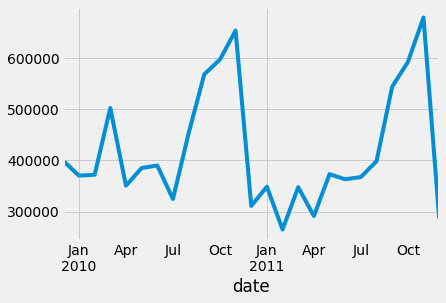

In [8]:
monthly_series.plot()

**DECOMPSITION OF Time Series Components**

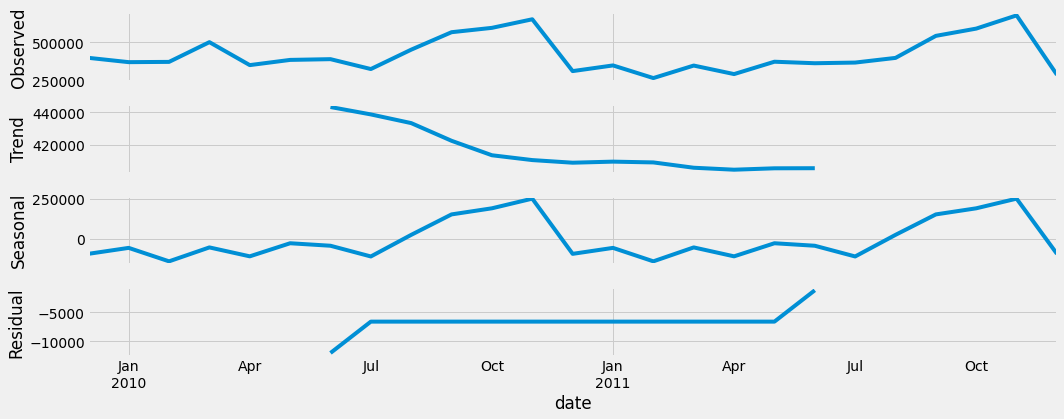

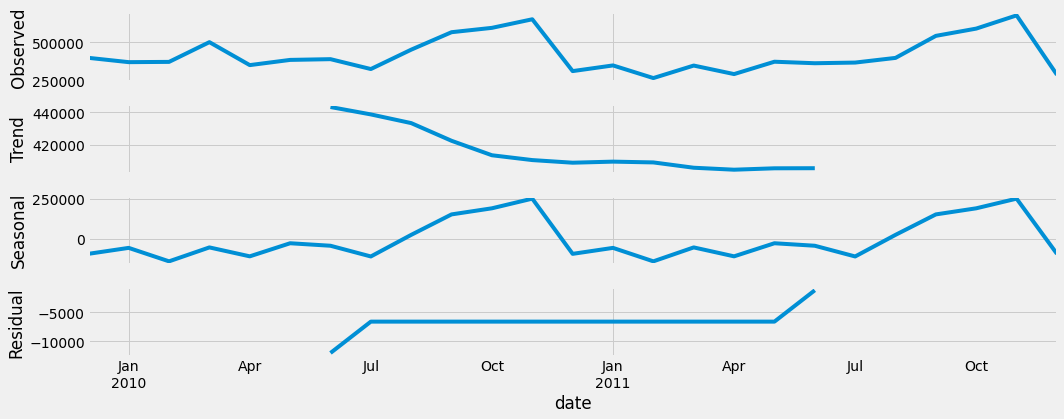

In [9]:
from pylab import rcParams
rcParams['figure.figsize']= 15,6

components= sm.tsa.seasonal_decompose(monthly_series)
components.plot()

In [10]:
trend= components.trend
seasonality= components.seasonal
remainder= components.resid

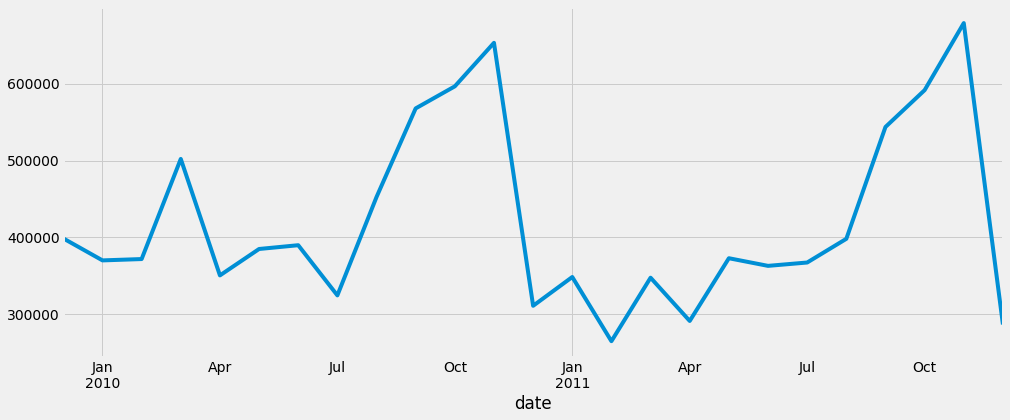

In [11]:
monthly_series.plot()

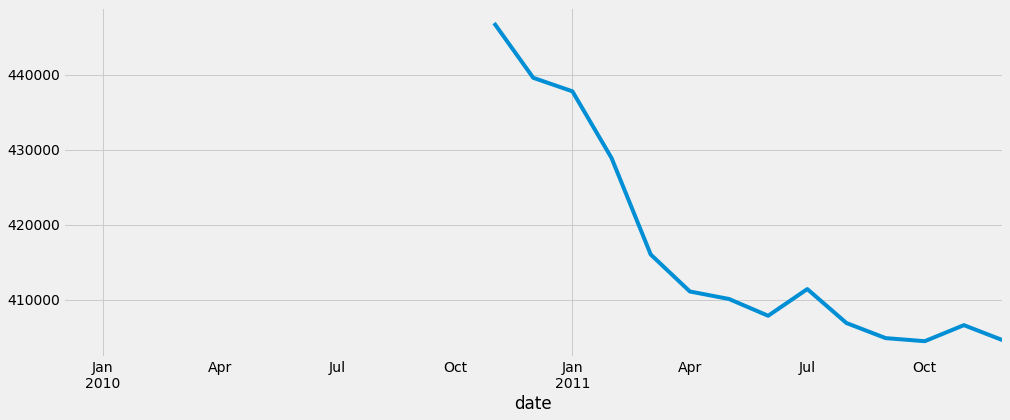

In [12]:
monthly_series.rolling(window=12).mean().plot()

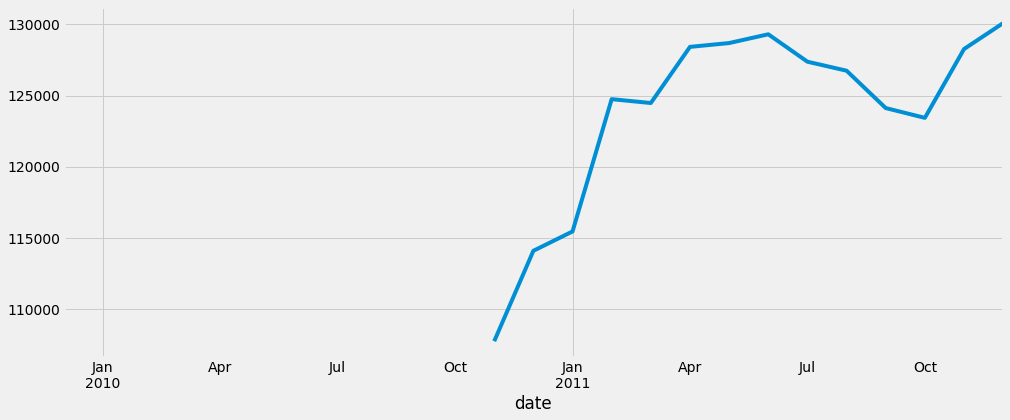

In [13]:
monthly_series.rolling(window=12).std().plot()

**Stationary Check**

In [14]:
ad_fuller_test= sm.tsa.stattools.adfuller(monthly_series,autolag='AIC')
ad_fuller_test

(-3.356898142962889,
 0.012518958188462888,
 2,
 22,
 {'1%': -3.769732625845229,
  '10%': -2.6425009917355373,
  '5%': -3.005425537190083},
 397.22710967925735)

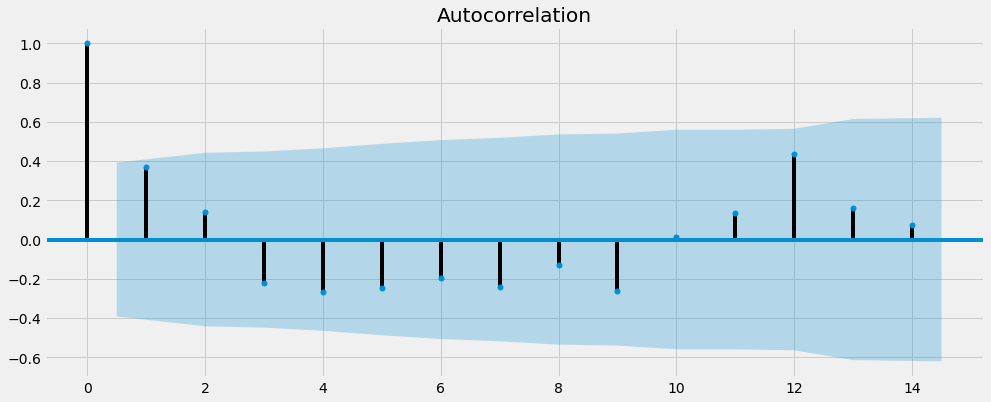

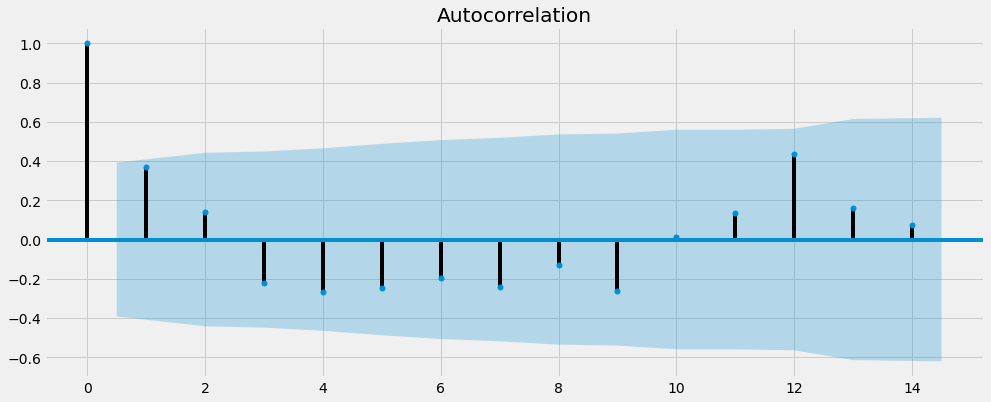

In [15]:
from statsmodels.graphics.tsaplots import plot_acf ,plot_pacf
plot_acf(monthly_series)

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


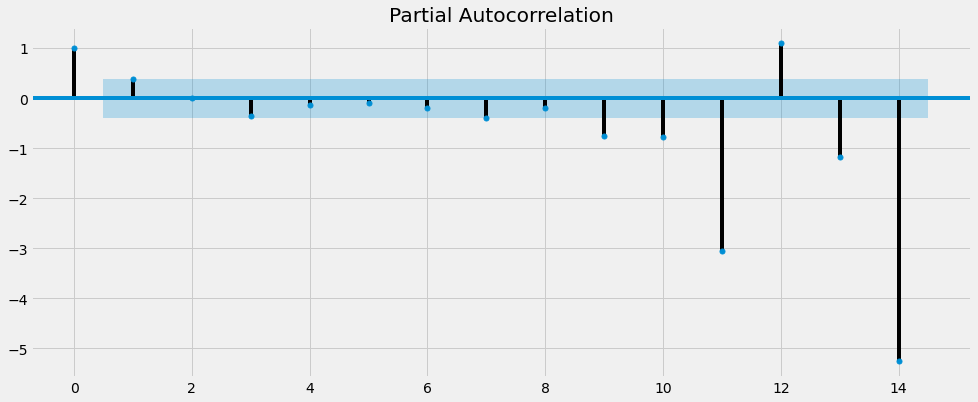

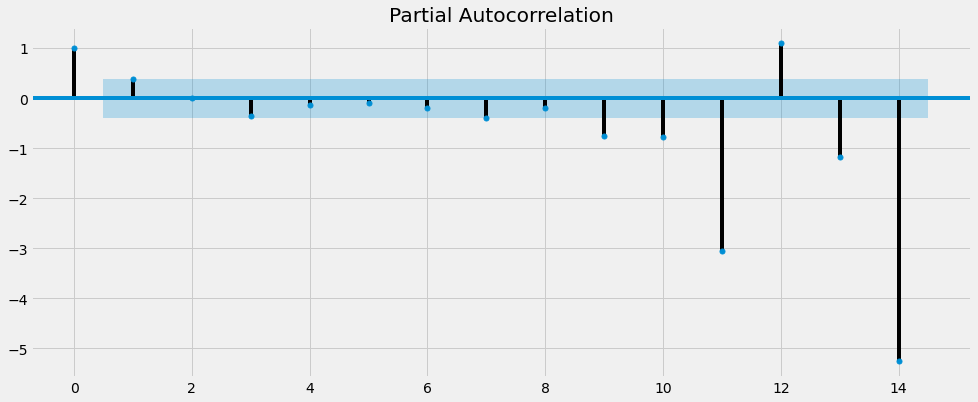

In [16]:
plot_pacf(monthly_series)

**SARMIX Model**

In [17]:
model_ma= sm.tsa.statespace.SARIMAX(monthly_series,order= (0,0,1))
results_ma= model_ma.fit()
results_ma.aic

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


708.0230586495467

In [18]:
model_AR= sm.tsa.statespace.SARIMAX(monthly_series,order= (1,0,0))
results_AR= model_AR.fit()
results_AR.aic

665.3244111102928

**TRYING ALL COMBINATIONS of P, Q, D, p, q, d**

In [19]:
import itertools       
           
P=D=Q=p=d=q= range(0,3)
S= 12
combinations= list(itertools.product(p,d,q,P,D,Q))
len(combinations)
arima_orders=[(x[0],x[1],x[2]) for x in combinations]
arima_orders[0][0]
seasonal_orders=[(x[3],x[4],x[5],S) for x in combinations]

results_data= pd.DataFrame(columns=['p','d','q','P','D','Q','AIC'])

In [20]:
results_data

,p,d,q,P,D,Q,AIC


In [21]:
len(combinations) 

729

**Calculating AIC in for LOOP for all possible combinations**

In [22]:
for i in range(len(combinations)):
     try:
      
          model = sm.tsa.statespace.SARIMAX(monthly_series,order=arima_orders[i],
                                        seasonal_order= seasonal_orders[i]
                                       )
          result= model.fit()
          results_data.loc[i,'p']= arima_orders[i][0]
          results_data.loc[i,'d']= arima_orders[i][1]
          results_data.loc[i,'q']= arima_orders[i][2]
          results_data.loc[i,'P']= seasonal_orders[i][0]
          results_data.loc[i,'D']= seasonal_orders[i][1]
          results_data.loc[i,'Q']= seasonal_orders[i][2]
          results_data.loc[i,'AIC']= result.aic
     except:
          continue

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/mlemodel.py:948: RuntimeWarning: invalid value encountered in true_divide
  (self.nobs - self.ssm.loglikelihood_burn)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting para

In [23]:
results_data.head()

,p,d,q,P,D,Q,AIC
0,0,0,0,0,0,0,722.316759
3,0,0,0,0,1,0,329.759999
6,0,0,0,0,2,0,30.25631
9,0,0,0,1,0,0,675.933769
18,0,0,0,2,0,0,6809880.461694


In [24]:
results_data[results_data.AIC == min(results_data.AIC)]

,p,d,q,P,D,Q,AIC
87,0,1,0,0,2,0,2.0
168,0,2,0,0,2,0,2.0


In [25]:
best_model= sm.tsa.statespace.SARIMAX(monthly_series,order=(0,1,0), seasonal_order= (0,2,0,12))

In [26]:
results =  best_model.fit()
results.aic

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/mlemodel.py:948: RuntimeWarning: invalid value encountered in true_divide
  (self.nobs - self.ssm.loglikelihood_burn)


2.0

In [27]:
monthly_series

date
2009-12-31    398708
2010-01-31    370128
2010-02-28    371871
2010-03-31    502101
2010-04-30    350604
2010-05-31    384960
2010-06-30    389880
2010-07-31    324638
2010-08-31    452551
2010-09-30    567806
2010-10-31    596497
2010-11-30    653074
2010-12-31    311063
2011-01-31    348522
2011-02-28    265043
2011-03-31    347623
2011-04-30    291369
2011-05-31    372948
2011-06-30    363014
2011-07-31    367372
2011-08-31    398190
2011-09-30    543654
2011-10-31    591551
2011-11-30    678760
2011-12-31    286778
Freq: M, Name: total_sales, dtype: int64

In [28]:
fitting= results.get_prediction(start= '2009-12-31')
fitting_mean= fitting.predicted_mean
forecast= results.get_forecast(steps=12)
forecast_mean= forecast.predicted_mean

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Unrecognized location 'upperleft'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  after removing the cwd from sys.path.


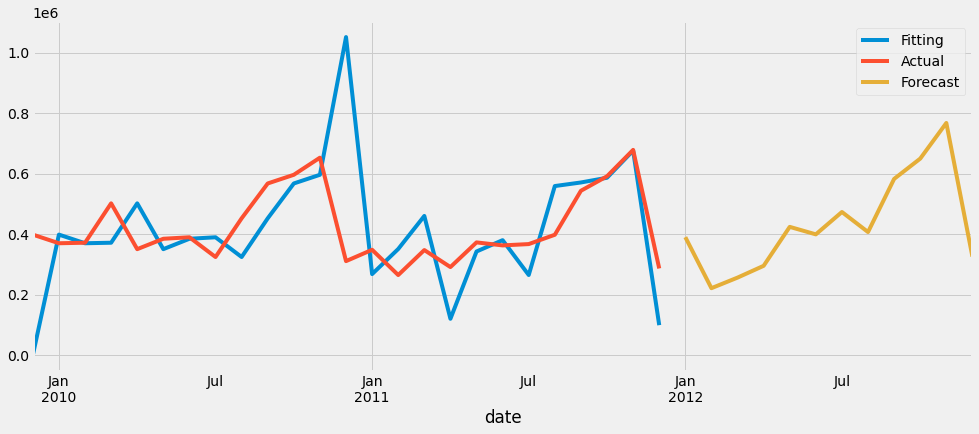

In [29]:
fitting_mean.plot(label='Fitting')
monthly_series.plot(label='Actual')
forecast_mean.plot(label='Forecast')
plt.legend(loc='upperleft')

In [30]:
mean_absolute_error_best_arima= abs(monthly_series-fitting_mean).mean()
mean_absolute_error_best_arima

114693.99333333336

In [31]:
rmse_best_model_arima_best_arima= np.sqrt((monthly_series-fitting_mean)**2).mean()
rmse_best_model_arima_best_arima

114693.99333333336

**HOLTWINTER EXPONENTIAL SMOOTHING**

In [32]:
import statsmodels as sm
sm.tsa.holtwinters.ExponentialSmoothing

statsmodels.tsa.holtwinters.ExponentialSmoothing

In [33]:
model_expo1= sm.tsa.holtwinters.ExponentialSmoothing(monthly_series,trend='add',
                                                     seasonal='add',seasonal_periods=12)

model_expo2= sm.tsa.holtwinters.ExponentialSmoothing(monthly_series,trend='mul',
                                                     seasonal='add',seasonal_periods=12)

model_expo3= sm.tsa.holtwinters.ExponentialSmoothing(monthly_series,trend='add',
                                                     seasonal='mul',seasonal_periods=12)

model_expo4= sm.tsa.holtwinters.ExponentialSmoothing(monthly_series,trend='mul',
                                                     seasonal='mul',seasonal_periods=12)


In [34]:
results_1= model_expo1.fit()
results_2= model_expo2.fit()
results_3= model_expo3.fit()
results_4= model_expo4.fit()

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [35]:
results_1.summary()

Dep. Variable:,endog,No. Observations:,25
Model:,ExponentialSmoothing,SSE,48838370297.732
Optimized:,True,AIC,566.823
Trend:,Additive,BIC,586.325
Seasonal:,Additive,AICC,680.823
Seasonal Periods:,12,Date:,"Sat, 13 Aug 2022"
Box-Cox:,False,Time:,14:56:25
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0526352,alpha,True
smoothing_slope,0.0526352,beta,True


In [36]:
results_2.summary()
results_3.summary()
results_4.summary()

Dep. Variable:,endog,No. Observations:,25
Model:,ExponentialSmoothing,SSE,28326494493.862
Optimized:,True,AIC,553.205
Trend:,Multiplicative,BIC,572.707
Seasonal:,Multiplicative,AICC,667.205
Seasonal Periods:,12,Date:,"Sat, 13 Aug 2022"
Box-Cox:,False,Time:,14:56:27
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4210526,alpha,True
smoothing_slope,0.0526316,beta,True


In [37]:
fit1= model_expo1.fit().predict(0,len(monthly_series))
fit2= model_expo2.fit().predict(0,len(monthly_series))
fit3= model_expo3.fit().predict(0,len(monthly_series))
fit4= model_expo4.fit().predict(0,len(monthly_series))

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [38]:
mae1= abs(monthly_series- fit1).mean()
mae2= abs(monthly_series- fit2).mean()
mae3= abs(monthly_series- fit3).mean()
mae4= abs(monthly_series- fit4).mean()

In [39]:
print(mae1, mae2, mae3, mae4)

23171.728448945152 29667.894863264697 28184.82093893889 28275.786507347886


In [40]:
forecast=model_expo1.fit().predict(0,len(monthly_series)+12)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Unrecognized location 'upperleft'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  This is separate from the ipykernel package so we can avoid doing imports until


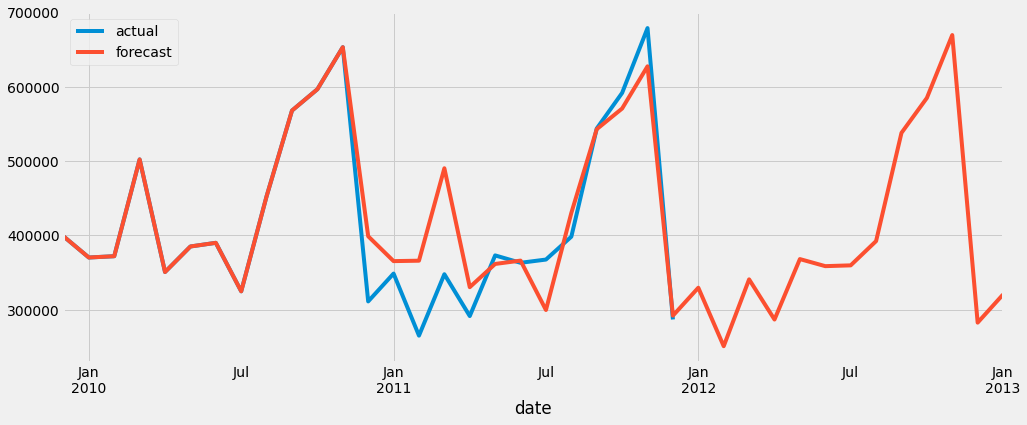

In [41]:
monthly_series.plot(label='actual')
forecast.plot(label='forecast')
plt.legend(loc='upperleft')